Import necessary Python Libraries

In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from xgboost import XGBRegressor
from scipy import stats
from scipy.stats import norm, skew


Read in the data set:

In [13]:
test = pd.read_csv('/Users/arianiherrera/Downloads/all/test.csv')
train = pd.read_csv('/Users/arianiherrera/Downloads/all/train.csv')

Dropping the ID and Sale price from Dataset

In [15]:
numerical_feats = train.dtypes[train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


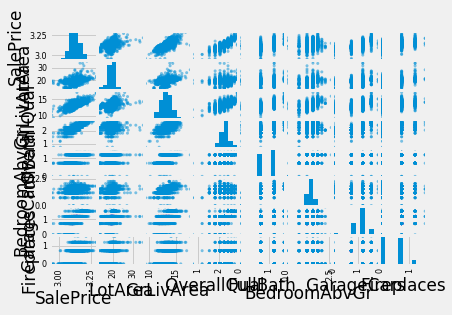

In [68]:
scatter_matrix(train[['SalePrice','LotArea','GrLivArea','OverallQual','FullBath','BedroomAbvGr','GarageCars',\
                        'Fireplaces']])
plt.show()

Ames Housing Dataset:

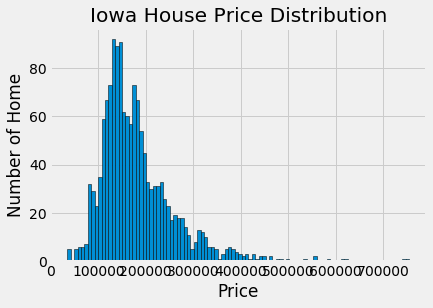

In [16]:
plt.style.use('fivethirtyeight')
plt.hist(train['SalePrice'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Price'); plt.ylabel('Number of Home'); 
plt.title('Iowa House Price Distribution');

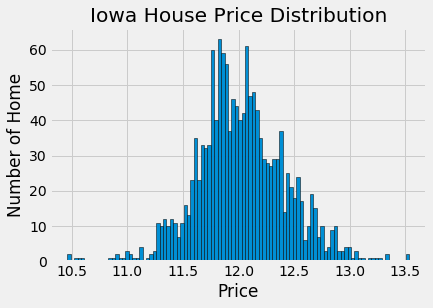

In [17]:
#Normalize the housing prices
train['SalePrice'] = np.log1p(train['SalePrice'])
plt.style.use('fivethirtyeight')
plt.hist(train['SalePrice'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Price'); plt.ylabel('Number of Home'); 
plt.title('Iowa House Price Distribution');

Analyzing from a macro prospective the correlation between all features

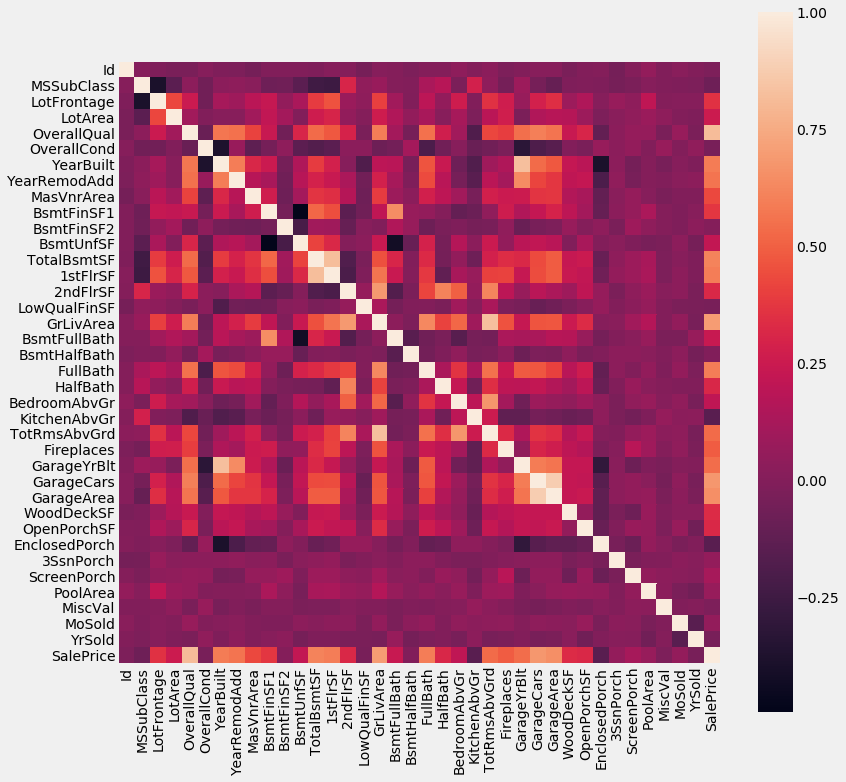

In [18]:
corr = train.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)

Missing Data showing NA 

In [19]:
train_na = (train.isnull().sum() / len(train)) * 100
all_data_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [21]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [22]:
missing_df = missing_values_table(train);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.
We will remove 4 columns.


Text(0.5,1,'Percent missing data by feature')

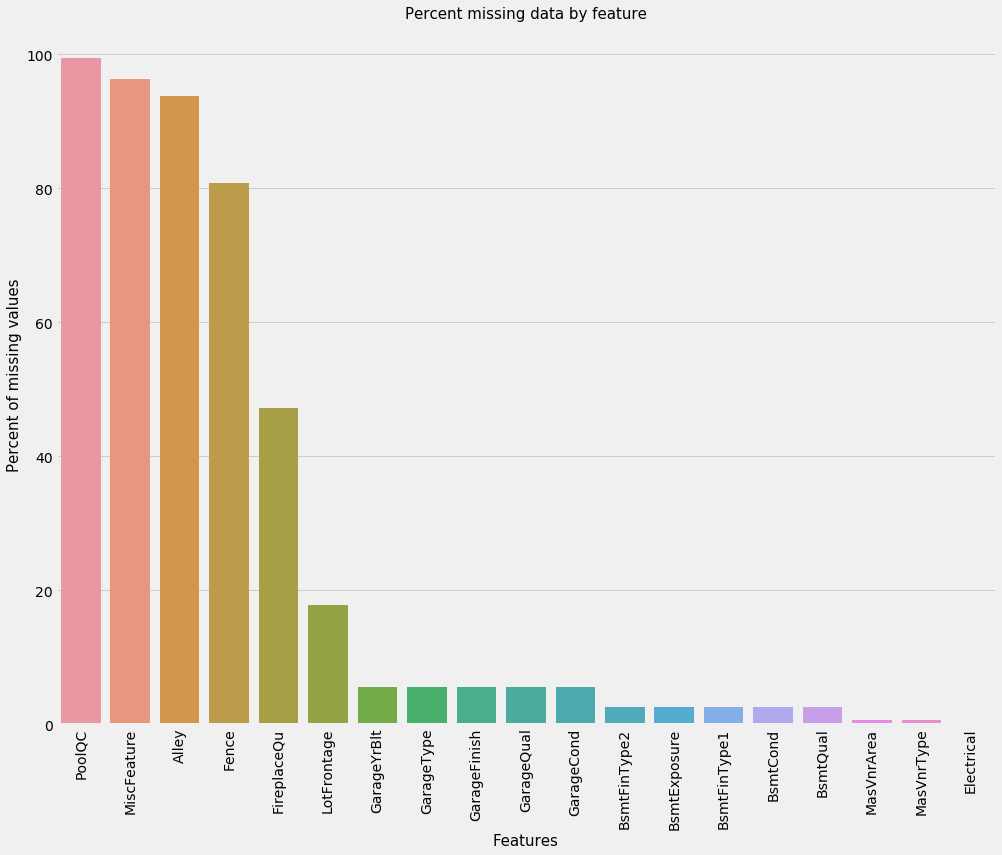

In [23]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [24]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Removing Data if more than 50% of the data is missing

In [25]:
def get_nan_cols(df, nan_percent=0.5):
    threshold = len(df.index) * nan_percent
    return [c for c in df.columns if sum(df[c].isnull()) >= threshold] 

In [26]:
get_nan_cols(train)

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [27]:
columns_to_use = train.columns

In [36]:
columns_to_use.drop(['Id','Alley', 'PoolQC', 'Fence', 'MiscFeature','SalePrice','Utilities'])

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchS

Cleaning up data that has NAs

In [30]:
for col in ('GarageType','GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')

In [31]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)

In [32]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')

In [33]:
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

In [37]:
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])

In [38]:
train["Functional"] = train["Functional"].fillna("Typ")

In [39]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

In [40]:
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])

In [41]:
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])

In [42]:
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

In [43]:
train['MSSubClass'] = train['MSSubClass'].fillna("None")

In [44]:
train["PoolQC"] = train["PoolQC"].fillna("None")

In [45]:
train["MiscFeature"] = train["MiscFeature"].fillna("None")

In [46]:
train["Alley"] = train["Alley"].fillna("None")

In [47]:
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

In [48]:
train["Fence"] = train["Fence"].fillna("None")

In [49]:
#taking some numerical features converting them into categorical features
train['MSSubClass'] = train['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
train['OverallCond'] = train['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [50]:
train['TotalSF'] = (
    train['BsmtFinSF1'].fillna(0) +
    train['BsmtFinSF2'].fillna(0) +
    train['1stFlrSF'].fillna(0) +
    train['2ndFlrSF'].fillna(0)
)

In [51]:
columnsofneed = train.columns
columnsofneed = columnsofneed.drop(['Id','Alley','PoolQC','Fence','MiscFeature','SalePrice','BsmtFinSF1',
                                    'BsmtFinSF2','1stFlrSF','2ndFlrSF','Utilities'])

In [52]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [53]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


Use box cox transformations for skewness more than 75

In [54]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

There are 35 skewed numerical features to Box Cox transform


Removing Outliers

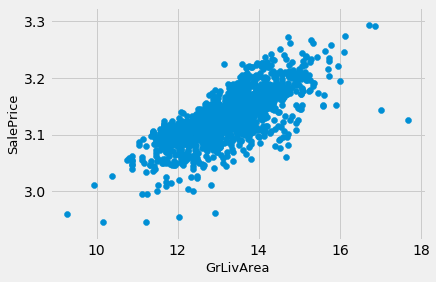

In [55]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

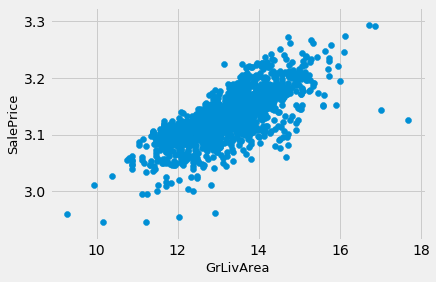

In [56]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [64]:
abs(train.corr()['SalePrice'].sort_values(ascending = False)).head(15)

SalePrice       1.000000
OverallQual     0.806093
TotalSF         0.740229
GrLivArea       0.728221
GarageCars      0.651380
1stFlrSF        0.608484
YearBuilt       0.585997
FullBath        0.583420
YearRemodAdd    0.566665
TotRmsAbvGrd    0.539066
GarageArea      0.512875
Fireplaces      0.506547
OpenPorchSF     0.453933
TotalBsmtSF     0.453373
MasVnrArea      0.421650
Name: SalePrice, dtype: float64

In [73]:
y_train = train[['SalePrice']]
X_train = train.drop(['SalePrice','Id'], axis=1)
X_test = df_test.drop(['Id'], axis=1)

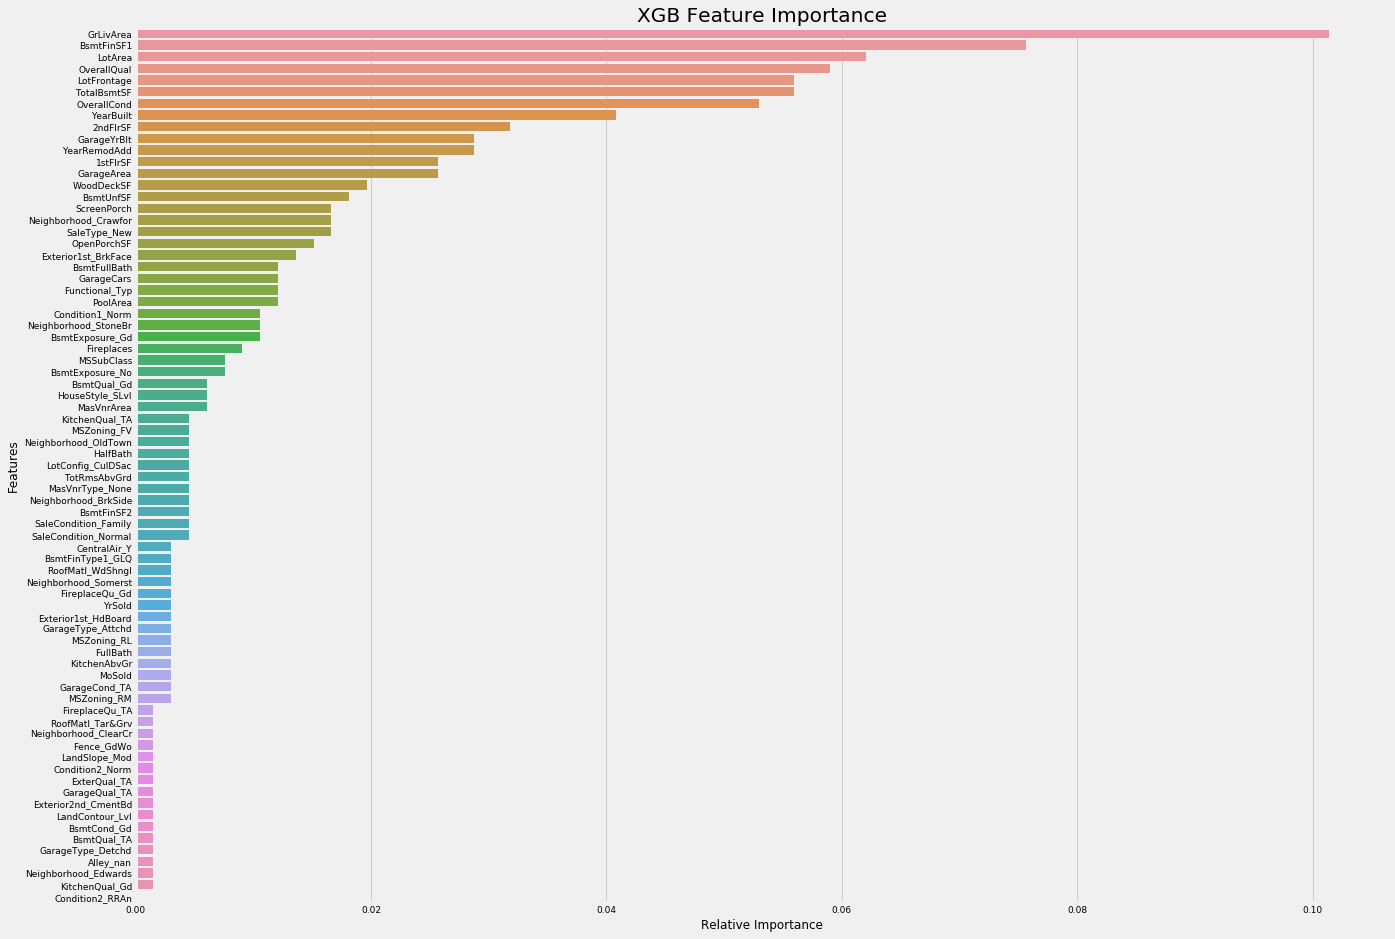

In [70]:
#Use XGBoost to find importance of features:#Use XGBo 
#Features must be numerical or boolean to test importance

xgb_x = pd.get_dummies(X_train, drop_first=True, dummy_na=True)
#xgb_x = X_train[["LotArea","OverallQual","YearBuilt","1stFlrSF","GrLivArea","FullBath"]]

#Using XGBoost:
xgb_model = XGBRegressor()
xgb_model.fit(xgb_x, y_train, verbose=False)

# Sort feature importances from model
indices = np.argsort(xgb_model.feature_importances_)[::-1]
indices = indices[:75]  #selecting top 75

# Visualise with barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=xgb_x.columns[indices], x = xgb_model.feature_importances_[indices], orient='h')
g.set_xlabel("Relative Importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB Feature Importance");

Using PCA to reduce dimensions for the data

In [74]:
X = X_train[columnsofneed]

In [75]:
from sklearn.decomposition import PCA
X = pd.get_dummies(X,drop_first=True,dummy_na=False) #dummy_na=True creates NA columns for category features w/ NA
pca = PCA().fit(X)

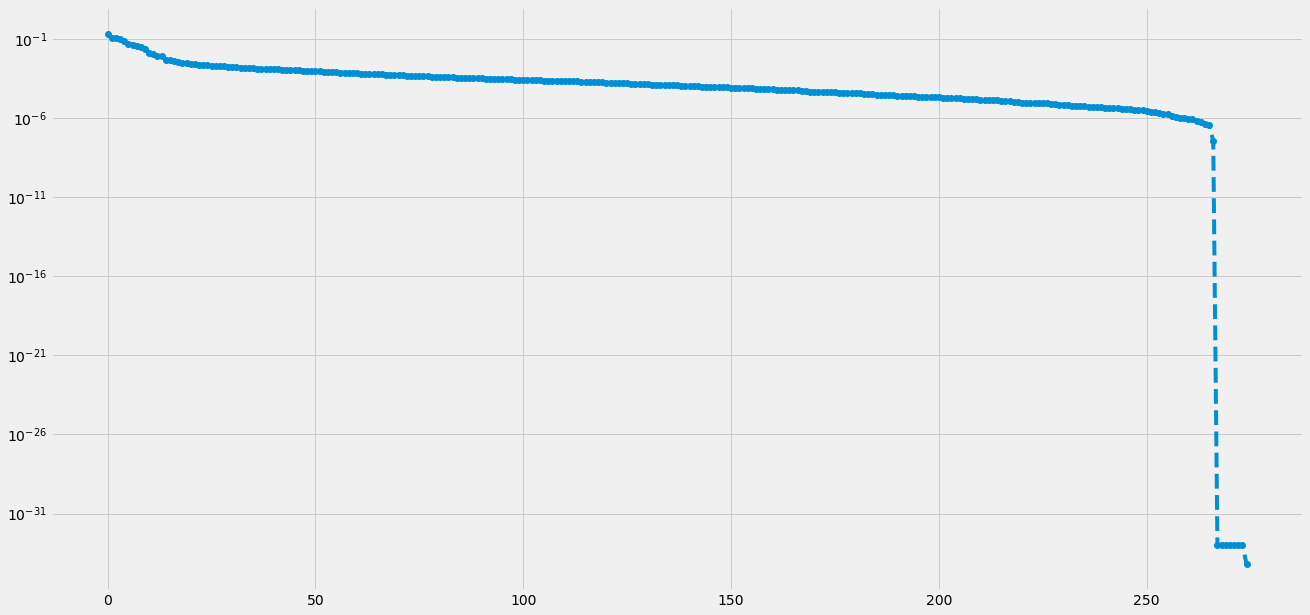

In [76]:
plt.figure(figsize=(20,10))
plt.semilogy(pca.explained_variance_ratio_, '--o')

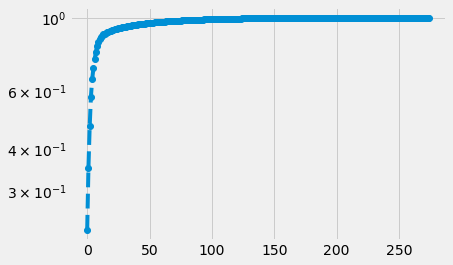

In [77]:
plt.semilogy(pca.explained_variance_ratio_.cumsum(), '--o')

In [78]:
X.shape

(1460, 275)

In [79]:
pca.explained_variance_ratio_.cumsum()[50]

0.9636008827109868

In [80]:
pca = PCA(n_components=50).fit(X)

In [81]:
pca.transform(X).shape
p_x = pca.transform(X)

Implementing the machine learning algorithims

In [86]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LogisticRegression, ElasticNetCV, Ridge
from sklearn import tree
import sklearn.model_selection as ms
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [105]:
#Grid Search for Ridge

RR_grid_param = {'alpha': range(5,30)}

para_search = GridSearchCV(estimator=Ridge(), param_grid=RR_grid_param, scoring='neg_mean_squared_error', cv=10, \
                           return_train_score=True)
para_search = para_search.fit(p_x, y)
print(para_search.best_score_)
print(para_search.best_params_)
para_search.best_estimator_

-0.00032066381449795547
{'alpha': 29}


Ridge(alpha=29, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [89]:
#Grid Search for RandomForest
RFR_grid_param = {'n_estimators': [100], 'max_features': ['auto'], 'max_depth': [None], \
                  'min_samples_split': [5], 'min_samples_leaf': [2]}

para_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=RFR_grid_param, \
                           scoring='neg_mean_squared_error', cv=10, return_train_score=True)
para_search = para_search.fit(p_x, y)
print(para_search.best_score_)
print(para_search.best_params_)
para_search.best_estimator_

-0.00043332081194026817
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [90]:
#Grid Search for Bayesian Ridge

BR_grid_param = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001, .00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
para_search = GridSearchCV(estimator=BayesianRidge(), param_grid=BR_grid_param, scoring='neg_mean_squared_error', cv=10, \
                           return_train_score=True)
para_search = para_search.fit(p_x, y)
print(para_search.best_score_)
print(para_search.best_params_)
para_search.best_estimator_

-0.00032079762250992273
{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X': True, 'lambda_1': 5e-06, 'lambda_2': 1e-08, 'n_iter': 200, 'tol': 1e-05}


BayesianRidge(alpha_1=1e-08, alpha_2=5e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=5e-06, lambda_2=1e-08, n_iter=200,
       normalize=False, tol=1e-05, verbose=False)

In [92]:
#Grid Search for Kernel Ridge

KR_grid_param = {'alpha': np.linspace(0.01, .2, num=15), 'coef0': [100], \
                 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}

para_search = GridSearchCV(estimator=KernelRidge(), param_grid=KR_grid_param, scoring='neg_mean_squared_error', cv=10, \
                           return_train_score=True)
para_search = para_search.fit(p_x, y)
print(para_search.best_score_)
print(para_search.best_params_)
para_search.best_estimator_

-0.000321183532956157
{'alpha': 0.2, 'coef0': 100, 'degree': 1, 'gamma': None, 'kernel': 'polynomial'}


KernelRidge(alpha=0.2, coef0=100, degree=1, gamma=None, kernel='polynomial',
      kernel_params=None)

In [95]:
LASS_grid_param = {'alpha':[0.0005, 0.0007,0.00075,0.0008], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300],'tol': [0.01], 'selection': ['random'], 'random_state': [None]}


para_search = GridSearchCV(estimator=Lasso(), param_grid=LASS_grid_param, scoring='neg_mean_squared_error', cv=10, \
                           return_train_score=True)
para_search = para_search.fit(p_x, y)
print(para_search.best_score_)
print(para_search.best_params_)
para_search.best_estimator_

-0.0003413385647148762
{'alpha': 0.0005, 'copy_X': True, 'fit_intercept': True, 'max_iter': 300, 'normalize': False, 'precompute': False, 'random_state': None, 'selection': 'random', 'tol': 0.01}


Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=300,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.01, warm_start=False)

  LR:  RMSE: 0.0179 (0.0029)  R^2: 0.8390 (0.0439)
TREE:  RMSE: 0.0296 (0.0024)  R^2: 0.5433 (0.0569)
 KRR:  RMSE: 0.0190 (0.0037)  R^2: 0.8192 (0.0543)
RIDG:  RMSE: 0.0179 (0.0029)  R^2: 0.8396 (0.0438)
LASS:  RMSE: 0.0184 (0.0030)  R^2: 0.8292 (0.0454)


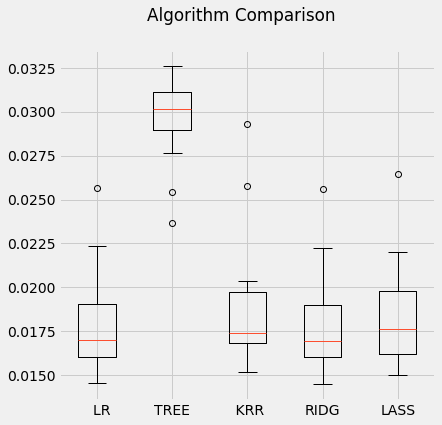

In [106]:
X = p_x
y = train['SalePrice']

#Linear Regression:
linear = linear_model.LinearRegression()
#Ridge Regression:
ridg = linear_model.Ridge(alpha=34)
#Lasso Regression
lass = linear_model.Lasso(alpha =0.0005, random_state=1)
#Kernel Ridge Regression:
krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#ElasticNet Model:
enet = linear_model.ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3),
#Decision Tree Regression:
dtree = tree.DecisionTreeRegressor()
#Random Forest:  ('RFOR',rfor)
rfor = RandomForestRegressor(n_estimators=500, max_depth=10,max_features='sqrt')



models = [('  LR', linear),('TREE', dtree),(' KRR',krr),('RIDG',ridg),('LASS',lass)]

results = []
names = []
for name, model in models:
    r_sq = ms.cross_val_score(model, X, y, cv=10, scoring='r2')
    rmse_score = np.sqrt((abs(ms.cross_val_score(model,X, y, cv=15, scoring='neg_mean_squared_error'))))
    results.append(rmse_score)
    names.append(name)
    msg = "%s:  RMSE: %.4f (%.4f)  R^2: %.4f (%.4f)" %(name,rmse_score.mean(),rmse_score.std(),r_sq.mean(),r_sq.std())
    print(msg)
    
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(6,6)
plt.show()

Running the model without PCA

  LR:  RMSE: 0.0173 (0.0051)  R^2: 0.8333 (0.0841)
TREE:  RMSE: 0.0242 (0.0030)  R^2: 0.7120 (0.0664)
 KRR:  RMSE: 0.0145 (0.0025)  R^2: 0.8938 (0.0292)
RIDG:  RMSE: 0.0148 (0.0033)  R^2: 0.8887 (0.0405)
LASS:  RMSE: 0.0166 (0.0030)  R^2: 0.8597 (0.0431)


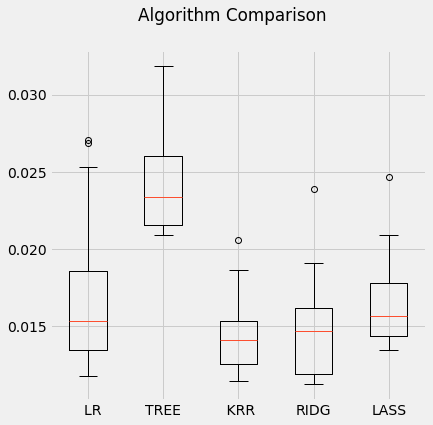

In [108]:
X = pd.get_dummies(train[columnsofneed],drop_first=True,dummy_na=False)
y = train['SalePrice']

#Linear Regression:
linear = linear_model.LinearRegression()
#Ridge Regression:
ridg = linear_model.Ridge(alpha=34)
#Lasso Regression
lass = linear_model.Lasso(alpha =0.0005, random_state=1)
#Kernel Ridge Regression:
krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#ElasticNet Model:
enet = linear_model.ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3),
#Decision Tree Regression:
dtree = tree.DecisionTreeRegressor()
#Random Forest:  ('RFOR',rfor)
rfor = RandomForestRegressor(n_estimators=500, max_depth=10,max_features='sqrt')



models = [('  LR', linear),('TREE', dtree),(' KRR',krr),('RIDG',ridg),('LASS',lass)]

results = []
names = []
for name, model in models:
    r_sq = ms.cross_val_score(model, X, y, cv=10, scoring='r2')
    rmse_score = np.sqrt((abs(ms.cross_val_score(model,X, y, cv=15, scoring='neg_mean_squared_error'))))
    results.append(rmse_score)
    names.append(name)
    msg = "%s:  RMSE: %.4f (%.4f)  R^2: %.4f (%.4f)" %(name,rmse_score.mean(),rmse_score.std(),r_sq.mean(),r_sq.std())
    print(msg)
    
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(6,6)
plt.show()

In [104]:
train['BsmtFinType2'].value_counts()

Unf     1256
Rec       54
LwQ       46
None      38
BLQ       33
ALQ       19
GLQ       14
Name: BsmtFinType2, dtype: int64